# Training SSD MobileNet v2 with TACO dataset

> This notebook will demonstrate training an SSD MobileNet v2 with the TACO (Trash Annotations in Context) (http://tacodataset.org/) dataset with TensorFlow. I did this a while ago in TensorFlow 1.14. I have not been able to make this work on GPU in this notebook unfortunately, if you can get this running on GPU as is, please let me know.

> I trained the models on Google Cloud with several GPU's for 100000 training steps and included the .pb, .uff and .engine file as a dataset. In this notebook I only did 10 training steps for demonstration purposes.

> It's also possible to convert this trained fronzen graph into uff format and from uff format to TensorRT engine. This engine can then be used in NVIDIA DeepStream to produce realtime trash detection as shown here: https://www.linkedin.com/feed/update/urn:li:activity:6695264486607130624/. Feel free to ask me about the converters between the formats.

## <center style="background-color: #6dc8b5; width:30%;">Contents</center>
* [Install TensorFlow Components](#tf_components)
* [Download Model](#download_model)
* [Reconstruct Model](#reconstruct_model)
* [Preprocess Data](#preprocess_data)
* [Construct Pipeline](#construct_pipeline)
* [Run Pipeline](#run_pipeline)
* [Export Model](#export_model)
* [Reconstruct Trained Model](#reconstruct_trained_model)
* [Cleanup](#cleanup)

<a class="anchor" id="tf_components"></a>
# Install TensorFlow Components

In [1]:
! pip3 install tensorflow==1.14.0

     |████████████████████████████████| 109.3 MB 60 kB/s s eta 0:00:01
     |████████████████████████████████| 50 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 3.1 MB 51.1 MB/s eta 0:00:01
     |████████████████████████████████| 488 kB 39.7 MB/s eta 0:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.1:
      Successfully uninstalled tensorflow-2.3.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We re

In [2]:
import tensorflow as tf
import os, subprocess, re
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import shutil
import json
from google.protobuf import text_format
import pprint
import random
from pathlib import Path
from google.protobuf import text_format

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
print(tf.__version__)

1.14.0


In [4]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone --depth 1 https://github.com/tensorflow/models.git -b v1.13.0 \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2431/2431), done.
remote: Total 2927 (delta 485), reused 2168 (delta 421), pack-reused 0 (from 0)
Receiving objects: 100% (2927/2927), 369.06 MiB | 39.80 MiB/s, done.
Resolving deltas: 100% (485/485), done.
Note: checking out '57e075203f8fba8d85e6b74f17f63d0a07da233a'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (2768/2768), done.


In [5]:
# install object_detection library
! pip3 install pycocotools > /dev/null
! cd ./models/research && \
    protoc object_detection/protos/*.proto --python_out=. && \
    python3 setup.py build > /dev/null && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/dist/object_detection-0.1-py3-none-any.whl > /dev/null
! cd ./models/research/slim && \
    python3 setup.py bdist_wheel > /dev/null
! python3 -m pip install --no-cache-dir ./models/research/slim/dist/slim-0.1-py3-none-any.whl > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [6]:
from object_detection.utils import dataset_util, label_map_util
from object_detection.dataset_tools.create_coco_tf_record import create_tf_example
from object_detection.protos import string_int_label_map_pb2
from object_detection.protos import pipeline_pb2
from object_detection.utils import visualization_utils as vis_util

<a class="anchor" id="download_model"></a>
# Download Model

This section shows how to download a [frozen Tensorflow graph](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/freeze_graph.py) from the [Tensorflow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

In [7]:
MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
DATA_DIR = './nn-models'
MODEL_DIR = os.path.join(DATA_DIR, MODEL)
URL = 'http://download.tensorflow.org/models/object_detection/%s.tar.gz' % MODEL
DOWNLOAD_PATH = '%s/%s.tar.gz' % (DATA_DIR, MODEL)

In [8]:
if not os.path.exists(DATA_DIR):
    subprocess.run(['mkdir', DATA_DIR])

In [9]:
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2

def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [10]:
def download():
    print("Downloading %s.." % MODEL)
    p = subprocess.run(['wget', '--show-progress', '--progress=bar:force', '-O', DOWNLOAD_PATH, URL])

    print("Unpacking..")
    p = subprocess.run(['tar', 'zxvf', DOWNLOAD_PATH, '-C', DATA_DIR])
    p = subprocess.run(['rm', DOWNLOAD_PATH])

    print("Checking..")
    pbfile = os.path.join(MODEL_DIR, 'frozen_inference_graph.pb')
    reconstruct(pbfile)

In [11]:
if os.path.exists(MODEL_DIR):
    subprocess.run(['rm', '-r', MODEL_DIR])
    subprocess.run(['mkdir', MODEL_DIR])
download()

Unpacking..
Checking..
Reconstructing Tensorflow model
Success!


<a class="anchor" id="reconstruct_model"></a>
# Reconstruct Model

This section shows how to reconstruct a Tensorflow model object from a [frozen Tensorflow graph](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/freeze_graph.py) file.

In [12]:
PB_PATH = "./nn-models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
LABEL_PATH = './models/research/object_detection/data/mscoco_label_map.pbtxt'
NCLASSES = 60

In [13]:
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

In [14]:
detection_graph = reconstruct(PB_PATH)

Reconstructing Tensorflow model
Success!


In [15]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

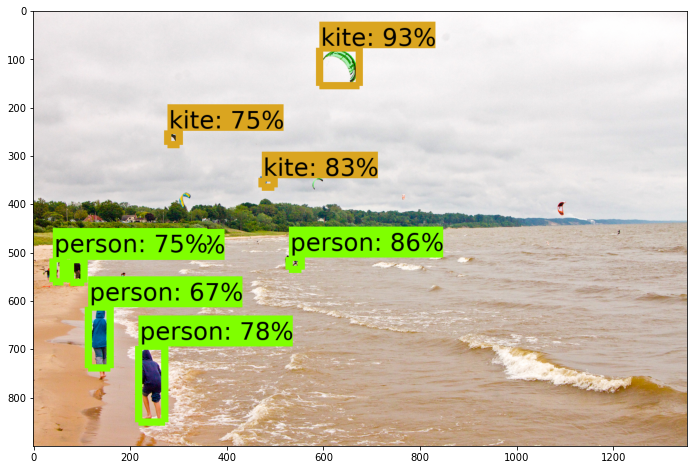

In [16]:
detect(detection_graph, './models/research/object_detection/test_images/image2.jpg')

<a class="anchor" id="preprocess_data"></a>
# Preprocess Data

In [17]:
TACO_DIR = './data/garbagedetection/TACO'
DATA_DIR = '/kaggle/input/tacotrashdataset/data'
IMAGES_SUB_DIR = 'images'
IMAGES_DIR = os.path.join(TACO_DIR, IMAGES_SUB_DIR)
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')

TRAIN_PROP = .80
SEED = 123

In [18]:
if not os.path.exists(IMAGES_DIR):
    subprocess.run(['mkdir', '-p', IMAGES_DIR])

In [19]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

images = data['images']
categories = data['categories']
annotations = data['annotations']

images_annotations = []
for idx, image in enumerate(images):
    image_id = int(image['id'])
    random_number = idx
    file_name = image['file_name']

    # rename files to unique numbers
    new_file_name = '%s.jpg' % str(random_number)
    file_location = '%s/%s' % (DATA_DIR, file_name)
    new_file_location = '%s/%s' % (IMAGES_DIR, new_file_name)
    if os.path.isfile(file_location):
        # print('renamed: %s to %s' % (file_location, new_file_location))
        shutil.copy(file_location, new_file_location)
    image['file_name'] = new_file_name
    image['folder'] = DATA_DIR

    # get annotations for the image
    _annotations = [a for a in annotations if int(a['image_id']) == image_id]

    # something wrong with y coordinates in data
    for a in _annotations:
        (x,y,w,h) = a['bbox']
        a['bbox'][1] = image['height'] - y - h

    images_annotations.append((image, _annotations))

In [20]:
np.random.seed(SEED)

images_annotations_idx = range(0,len(images_annotations))

images_annotations_train_idx = np.random.choice(
    len(images_annotations),
    size=int(len(images_annotations)*TRAIN_PROP),
    replace=False
)
images_annotations_train = [images_annotations[i] for i in images_annotations_train_idx]

images_annotations_val_idx = np.random.choice(
    list(set(images_annotations_idx)-set(images_annotations_train_idx)),
    size=int(len(images_annotations_idx)*(1-TRAIN_PROP)/2),
    replace=False
)
images_annotations_val = [images_annotations[i] for i in images_annotations_val_idx]

images_annotations_test_idx = list(set(images_annotations_idx)-set(images_annotations_train_idx)-set(images_annotations_val_idx))
images_annotations_test = [images_annotations[i] for i in images_annotations_test_idx]

print(
'''
# TRAIN IMAGES: %d
# VALIDATION IMAGES: %d
# TEST IMAGES: %d
''' % (len(images_annotations_train), len(images_annotations_val), len(images_annotations_test))
)


# TRAIN IMAGES: 1200
# VALIDATION IMAGES: 149
# TEST IMAGES: 151



In [21]:
LABEL_PATH = os.path.join(TACO_DIR, 'labelmap.pbtxt')

if not os.path.exists(LABEL_PATH):
    print('Building label map from examples')

    from object_detection.protos import string_int_label_map_pb2
    from google.protobuf import text_format

    labelmap = string_int_label_map_pb2.StringIntLabelMap()
    for category in categories:
        item = labelmap.item.add()
        # label map id 0 is reserved for the background label
        item.id = int(category['id'])+1
        item.name = category['name']

    with open(LABEL_PATH, 'w') as f:
        f.write(text_format.MessageToString(labelmap))

    print('Label map witten to labelmap.pbtxt')
else:
    print('Reusing existing labelmap.pbtxt')

with open(LABEL_PATH, 'r') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [22]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [23]:
def build_tfrecords(dataset, output_path, images_annotations, category_index):
    writer = tf.compat.v1.python_io.TFRecordWriter(output_path)
    label_map_dict = label_map_util.get_label_map_dict(LABEL_PATH)

    print("Building TFRecord files for dataset: %s" % dataset)

    for idx, (image, _annotations) in enumerate(images_annotations):
        if idx % 100 == 0:
            print('%d of %d annotations' % (idx, len(images_annotations)))

        _, tf_example, num_annotations_skipped = create_tf_example(
            image=image,
            annotations_list=_annotations,
            image_dir=IMAGES_DIR,
            category_index=category_index,
            include_masks=False
        )

        writer.write(tf_example.SerializeToString())

    writer.close()
    print("Done!")

In [24]:
# need a category_index here 0 based for making tf-records
_category_index = label_map_util.create_category_index(data['categories'])

datasets = [('train', images_annotations_train), ('test', images_annotations_test), ('val', images_annotations_val)]
for dataset,images_annotations in datasets:
    output_path = os.path.join(TACO_DIR, '%s.record' % dataset)
    build_tfrecords(dataset, output_path, images_annotations, _category_index)

Building TFRecord files for dataset: train
0 of 1200 annotations
100 of 1200 annotations
200 of 1200 annotations
300 of 1200 annotations
400 of 1200 annotations
500 of 1200 annotations
600 of 1200 annotations
700 of 1200 annotations
800 of 1200 annotations
900 of 1200 annotations
1000 of 1200 annotations
1100 of 1200 annotations
Done!
Building TFRecord files for dataset: test
0 of 151 annotations
100 of 151 annotations
Done!
Building TFRecord files for dataset: val
0 of 149 annotations
100 of 149 annotations
Done!


<a class="anchor" id="construct_pipeline"></a>
# Construct Pipeline

In [25]:
BATCH_SIZE = 12 # 24
BATCH_NMS_SCORE_THRESHOLD = .1
TENSORBOARD_NUM_IMAGES = 20

In [26]:
SRC_CONFIG_TEMPLATE_PATH = './nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config'
SRC_CHECKPOINT_PATH =  './nn-models/ssd_mobilenet_v2_coco_2018_03_29/model.ckpt'

MODEL_DIR = './nn-models/garbagedetection/ssd_mobilenet_v2/'
DATA_DIR = './data/garbagedetection/TACO/data/'

CHECKPOINT_PATH_HOST = os.path.join(MODEL_DIR, 'model.ckpt')
LABEL_MAP_PATH_HOST = os.path.join(TACO_DIR, 'labelmap.pbtxt')
TRAIN_RECORDS_PATH_HOST = os.path.join(TACO_DIR, 'train.record')
VAL_RECORDS_PATH_HOST = os.path.join(TACO_DIR, 'val.record')

In [27]:
label_map_dict = label_map_util.get_label_map_dict(os.path.join(TACO_DIR, 'labelmap.pbtxt'))
NUM_CLASSES = len(label_map_dict.keys())

In [28]:
print('''
Config parameters:

CHECKPOINT_PATH_HOST = %s
LABEL_MAP_PATH_HOST = %s
TRAIN_RECORDS_PATH_HOST = %s
VAL_RECORDS_PATH_HOST = %s
BATCH_SIZE = %d
NUM_CLASSES = %d
BATCH_NMS_SCORE_THRESHOLD = %f
TENSORBOARD_NUM_IMAGES = %d
''' % (
    CHECKPOINT_PATH_HOST, 
    LABEL_MAP_PATH_HOST,
    TRAIN_RECORDS_PATH_HOST,
    VAL_RECORDS_PATH_HOST,
    BATCH_SIZE,
    NUM_CLASSES,
    BATCH_NMS_SCORE_THRESHOLD,
    TENSORBOARD_NUM_IMAGES
))


Config parameters:

CHECKPOINT_PATH_HOST = ./nn-models/garbagedetection/ssd_mobilenet_v2/model.ckpt
LABEL_MAP_PATH_HOST = ./data/garbagedetection/TACO/labelmap.pbtxt
TRAIN_RECORDS_PATH_HOST = ./data/garbagedetection/TACO/train.record
VAL_RECORDS_PATH_HOST = ./data/garbagedetection/TACO/val.record
BATCH_SIZE = 12
NUM_CLASSES = 60
BATCH_NMS_SCORE_THRESHOLD = 0.100000
TENSORBOARD_NUM_IMAGES = 20



*Note: Below, we patch `ssd_mobilenet_v2_coco_2018_03_29/pipeline.config/pipeline.config` since it includes `batch_norm_trainable`, which was removed from `pipeline_pb2` proto (see [here](https://stackoverflow.com/questions/49880939/tf-object-detection-api-detection-model-retraining-object-detection-protos-ssd)). Alternatively, `/app/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config` can be used. However, in this version the kernel size of the convolutional_box_predictor is set to 1 instead of 3, which leads to omission of checkpoint loading for this layer*

In [29]:
%%bash
echo "
diff --git a/models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config b/pipeline.config
index 1853c65..0b459dd 100755
--- a/models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
+++ b/pipeline.config
@@ -32,7 +32,6 @@ model {
           train: true
         }
       }
-      batch_norm_trainable: true
       use_depthwise: true
     }
     box_coder {
" > ssd_mobilenet_v2_coco_2018_03_29_pipeline.config.patch

In [30]:
! patch -N './nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config' < ./ssd_mobilenet_v2_coco_2018_03_29_pipeline.config.patch

patching file ./nn-models/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config


In [31]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.compat.v2.io.gfile.GFile(SRC_CONFIG_TEMPLATE_PATH, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [32]:
pipeline_config.model.ssd.num_classes = NUM_CLASSES
pipeline_config.train_config.batch_size = BATCH_SIZE
pipeline_config.train_config.fine_tune_checkpoint = CHECKPOINT_PATH_HOST
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = TRAIN_RECORDS_PATH_HOST
pipeline_config.train_input_reader.label_map_path = LABEL_MAP_PATH_HOST
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[0] = VAL_RECORDS_PATH_HOST
pipeline_config.eval_input_reader[0].label_map_path = LABEL_MAP_PATH_HOST
pipeline_config.model.ssd.post_processing.batch_non_max_suppression.score_threshold = BATCH_NMS_SCORE_THRESHOLD
pipeline_config.eval_config.num_visualizations = TENSORBOARD_NUM_IMAGES

In [33]:
if not os.path.exists(MODEL_DIR):
    subprocess.run(['mkdir', '-p', MODEL_DIR])

config_text = text_format.MessageToString(pipeline_config)
with tf.compat.v2.io.gfile.GFile(os.path.join(MODEL_DIR, 'pipeline.config'), "wb") as f:
    f.write(config_text)

In [34]:
! cp -r $SRC_CHECKPOINT_PATH\.* $MODEL_DIR

<a class="anchor" id="run_pipeline"></a>
# Run Pipeline

In [35]:
MODEL_ROOT_DIR = './nn-models/garbagedetection/ssd_mobilenet_v2'
CONFIG_PATH = os.path.join(MODEL_ROOT_DIR, 'pipeline.config')
TRAINING_STEPS = 10
EVAL_STEPS = 10

In [36]:
! python3 ./models/research/object_detection/model_main.py \
    --pipeline_config_path=$CONFIG_PATH \
    --model_dir=$MODEL_ROOT_DIR \
    --alsologtostderr \
    --num_train_steps=$TRAINING_STEPS \
    --num_eval_steps=$EVAL_STEPS

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

<a class="anchor" id="export_model"></a>
# Export Model

In [37]:
! python3 ./models/research/object_detection/export_inference_graph.py --input_type=image_tensor --pipeline_config_path=$MODEL_ROOT_DIR/pipeline.config --trained_checkpoint_prefix=$MODEL_ROOT_DIR/model.ckpt-$TRAINING_STEPS --output_directory=$MODEL_ROOT_DIR

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

<a class="anchor" id="reconstruct_trained_model"></a>
# Reconstruct Trained Model

Following image is done with the reconstructed model of 10 training steps to show it reconstructed as a working frozen graph.

In [38]:
trained_detection_graph = reconstruct('./nn-models/garbagedetection/ssd_mobilenet_v2/frozen_inference_graph.pb')

Reconstructing Tensorflow model
Success!


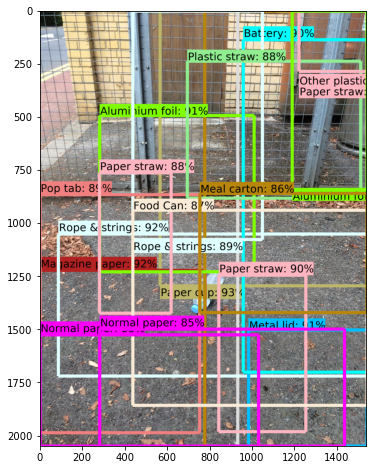

In [39]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000000.jpg')

Following images are done with the already trained model of 100000 training steps.

In [40]:
trained_detection_graph = reconstruct('/kaggle/input/trained-models-taco-trash-annotations-in-context/ssd_mobilenet_v2_taco_2018_03_29.pb')

Reconstructing Tensorflow model
Success!


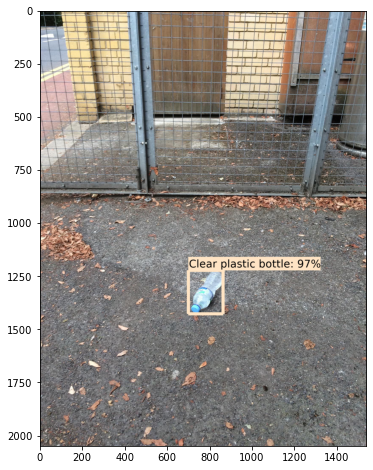

In [41]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_1/000000.jpg')

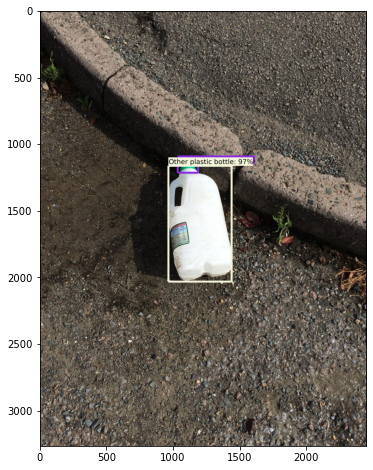

In [42]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_2/000000.JPG')

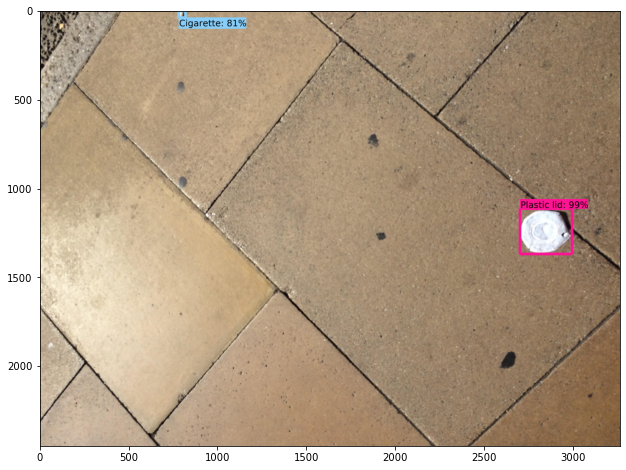

In [43]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_3/IMG_4852.JPG')

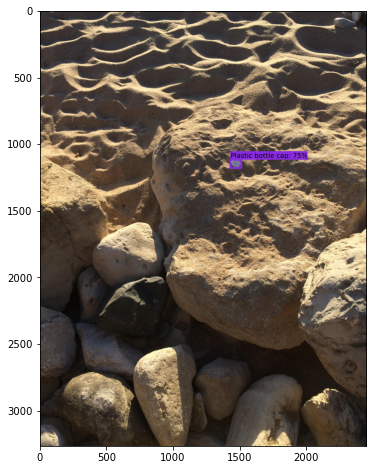

In [44]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_4/000000.JPG')

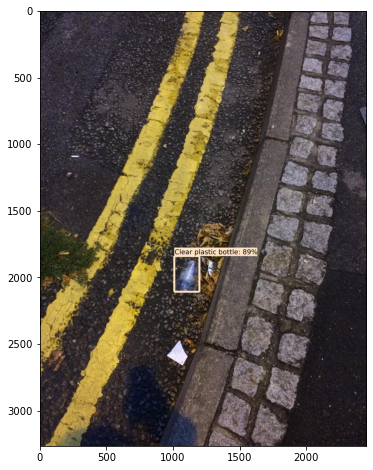

In [45]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_5/000000.JPG')

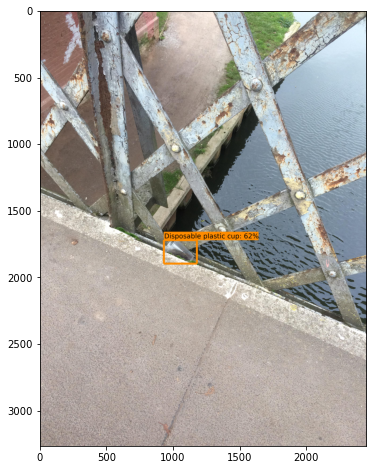

In [46]:
detect(trained_detection_graph, '/kaggle/input/tacotrashdataset/data/batch_6/000000.JPG')

<a class="anchor" id="cleanup"></a>
# Cleanup

In [ ]:
! rm -rf ./models && rm -rf ./data